# Lightweight Martian Terrain Segmentation with Explainability

This notebook demonstrates:

- Loading the AI4Mars dataset (Hugging Face: `hassanjbara/AI4MARS`).
- Training a lightweight U-Net on Martian terrain labels:
  - Classes: soil, bedrock, sand, big rock (null pixels ignored).
- Evaluating pixel accuracy and mean IoU.
- Visualizing predictions vs. ground truth.
- Explainability:
  - Grad-CAM heatmaps.
  - Integrated Gradients saliency.
  - "Neural PCA" of intermediate feature activations.


In [ ]:
import os
import random
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from models import create_unet
from dataloader import (
    create_ai4mars_dataloaders,
    AI4MARS_CLASS_NAMES,
    AI4MARS_IGNORE_INDEX,
)
from optimizers import create_optimizer
from train_utils import train_one_epoch, evaluate, save_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_size = 256
batch_size = 10
num_workers = 4
num_classes = len(AI4MARS_CLASS_NAMES)
num_epochs = 12

learning_rate = 5e-3
weight_decay = 1e-2
use_muon = False       
use_amp = True        

out_dir = Path("./outputs")
out_dir.mkdir(exist_ok=True, parents=True)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


/home/georg/miniconda3/envs/deep_learning_ex_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Data: AI4Mars dataloaders (train/val/test)
loaders = create_ai4mars_dataloaders(
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    val_fraction=0.1,
    to_rgb=False,
    seed=seed,
    cache_dir="./data/hf_cache",  
    #max_train_samples=100,         
    #max_test_samples=50,
    use_local_disk_copy=True,
    local_disk_path="./data/ai4mars_hf_on_disk",
    scan_spurious=False,
    valid_indices_cache_dir="./data/ai4mars_valid_indices",
)

train_loader = loaders.train
val_loader = loaders.val
test_loader = loaders.test

print(
    f"Train batches: {len(train_loader)}, "
    f"Val batches: {len(val_loader)}, "
    f"Test batches: {len(test_loader)}"
)


[AI4MarsHFDataset] Loaded 13018 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_train.npy
[AI4MarsHFDataset] Loaded 1449 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_val.npy
[AI4MarsHFDataset] Loaded 1597 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_test.npy
Train batches: 1302, Val batches: 145, Test batches: 160


In [3]:
# Model & optimizer
model = create_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=32,  # adjust for lighter/heavier model
    bilinear=True,
)
model.to(device)

from optimizers import create_optimizer, create_cosine_scheduler_with_warmup

# Create optimizer
optimizer = create_optimizer(
    model,
    lr=learning_rate,
    weight_decay=weight_decay,
    use_muon=False,
)

# Compute total training steps
num_update_steps_per_epoch = len(train_loader)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(0.1 * num_training_steps)  # e.g. 10% warmup

scheduler = create_cosine_scheduler_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)



[optimizers] Using NAdam (NadamW-style) optimizer.


In [4]:

# make sure checkpoint dir exists
Path("checkpoints").mkdir(parents=True, exist_ok=True)

history = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}

# initialize best validation mIoU to something very low
best_val_miou = -1.0  # mIoU is in [0,1], so this is safe

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_metrics = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        num_classes=num_classes,
        use_amp=use_amp,
        use_tqdm=True,
        epoch=epoch,
        num_epochs=num_epochs,
        scheduler=scheduler,
    )

    val_metrics = evaluate(
        model=model,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
        use_tqdm=True,
    )

    # checkpoint if validation mIoU improved
    if val_metrics["miou"] > best_val_miou:
        best_val_miou = val_metrics["miou"]
        save_checkpoint(
            path="checkpoints/best_model.pt",
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            metrics={"val_miou": best_val_miou},
        )

    history["train_loss"].append(train_metrics["loss"])
    history["train_miou"].append(train_metrics["miou"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)



Epoch 1/1


Train Epoch 1/1:   0%|          | 0/1302 [00:00<?, ?batch/s]/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[checkpoint] Saved checkpoint to checkpoints/best_model.pt
  Train - loss: 0.7257, mIoU: 0.3687, pix acc: 0.7025
  Val   - loss: 0.4172, mIoU: 0.5300, pix acc: 0.8624


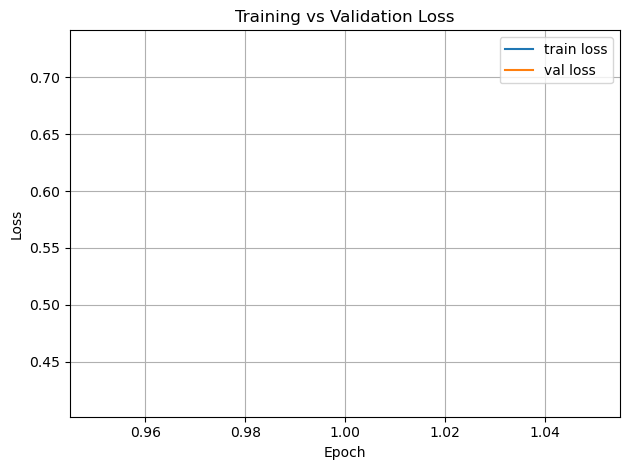

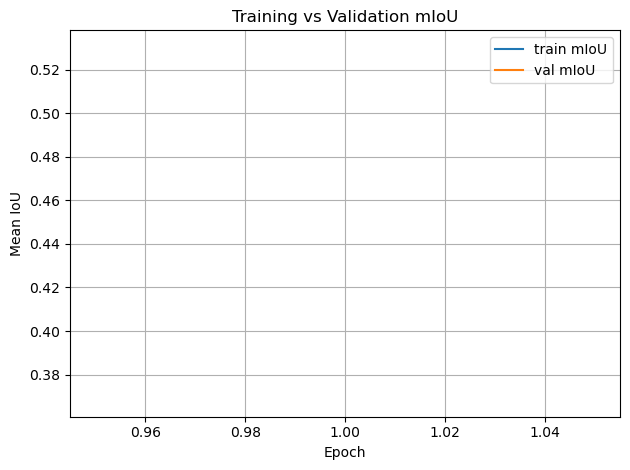

In [5]:
# Plot training curves
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history["train_miou"], label="train mIoU")
plt.plot(epochs, history["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from train_utils import load_checkpoint

info = load_checkpoint(
    path="checkpoints/best_model.pt",
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    map_location=device,
)

print("Restored from epoch:", info["epoch"])
print("Stored metrics:", info["metrics"])


[checkpoint] Loaded model weights from checkpoints/best_model.pt
[checkpoint] Restored optimizer state.
[checkpoint] Restored scheduler state.
Restored from epoch: 1
Stored metrics: {'val_miou': 0.5299948656087929}


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=m

In [7]:
# Evaluate on test set
test_metrics = evaluate(
    model=model,
    dataloader=test_loader,
    device=device,
    num_classes=num_classes,
)

print("\nTest metrics:")
print(
    f"  loss: {test_metrics['loss']:.4f}, "
    f"mIoU: {test_metrics['miou']:.4f}, "
    f"pix acc: {test_metrics['pixel_acc']:.4f}"
)



Test metrics:
  loss: 0.4623, mIoU: 0.5114, pix acc: 0.8391


/tmp/ipykernel_27225/3601530549.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


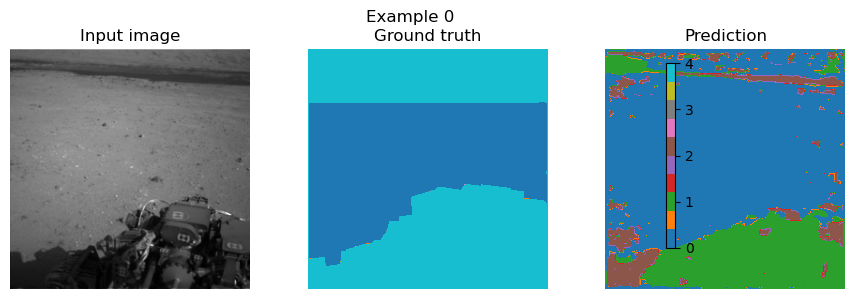

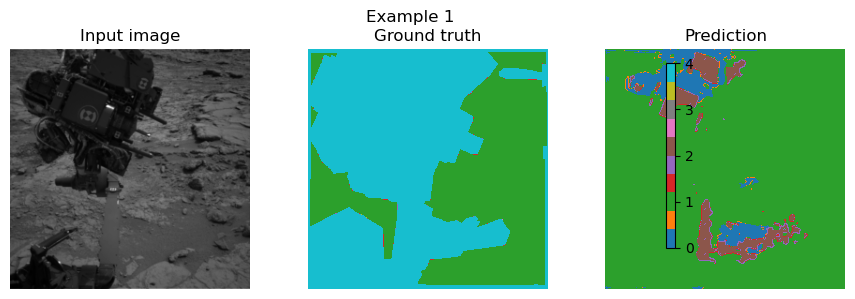

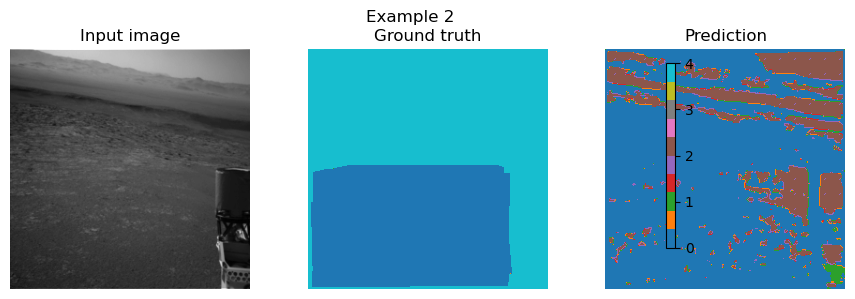

In [8]:
# Helper: visualize predictions vs ground truth
def decode_mask(mask_tensor):
    """Convert a [H,W] mask with indices into a numpy array for plotting."""
    mask_np = mask_tensor.cpu().numpy()
    return mask_np


def show_predictions(model, dataloader, num_examples: int = 3):
    model.eval()
    imgs, masks = next(iter(dataloader))

    imgs = imgs.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=1)

    for i in range(min(num_examples, imgs.size(0))):
        img = imgs[i, 0].cpu().numpy()  # [H,W]
        gt = decode_mask(masks[i])
        pred = decode_mask(preds[i])

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("Input image")
        axes[0].axis("off")

        im1 = axes[1].imshow(gt, vmin=0, vmax=num_classes, cmap="tab10")
        axes[1].set_title("Ground truth")
        axes[1].axis("off")

        im2 = axes[2].imshow(pred, vmin=0, vmax=num_classes, cmap="tab10")
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.8)
        plt.suptitle(f"Example {i}")
        plt.tight_layout()
        plt.show()


show_predictions(model, test_loader, num_examples=3)


Scanning dataset once to find examples per class...

=== Class 'soil' (id=0) | 3 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


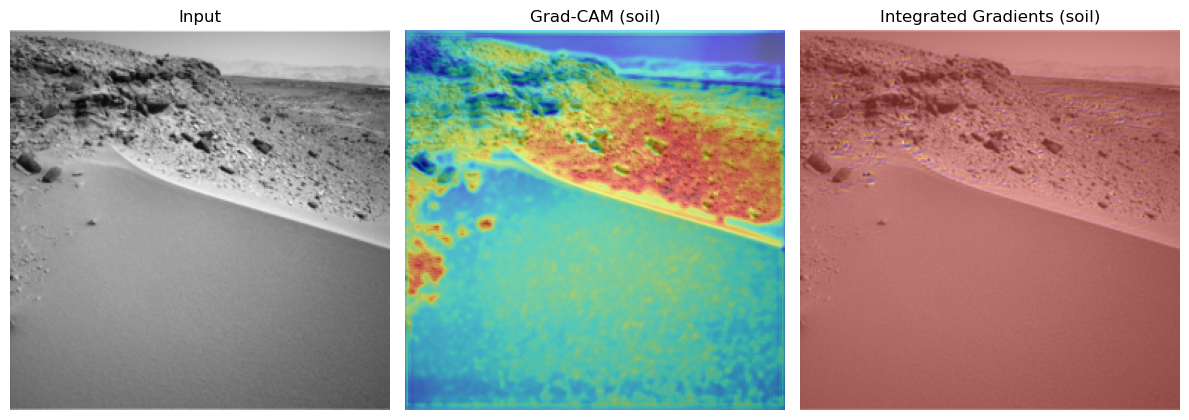


=== Class 'bedrock' (id=1) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 1)


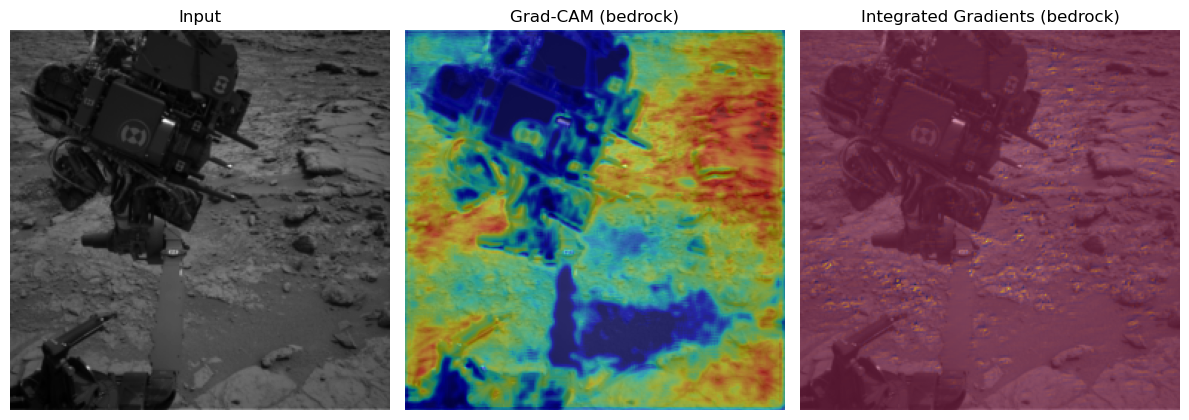


=== Class 'sand' (id=2) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


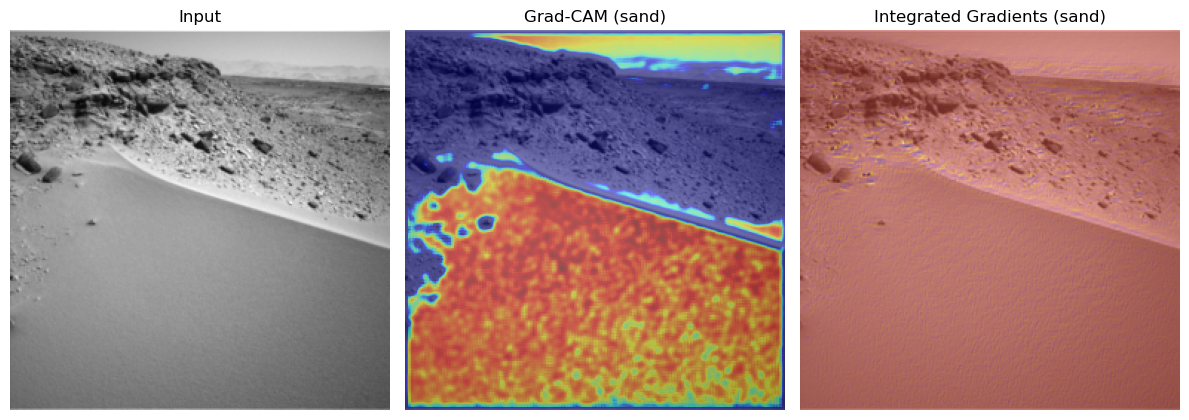


=== Class 'big_rock' (id=3) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


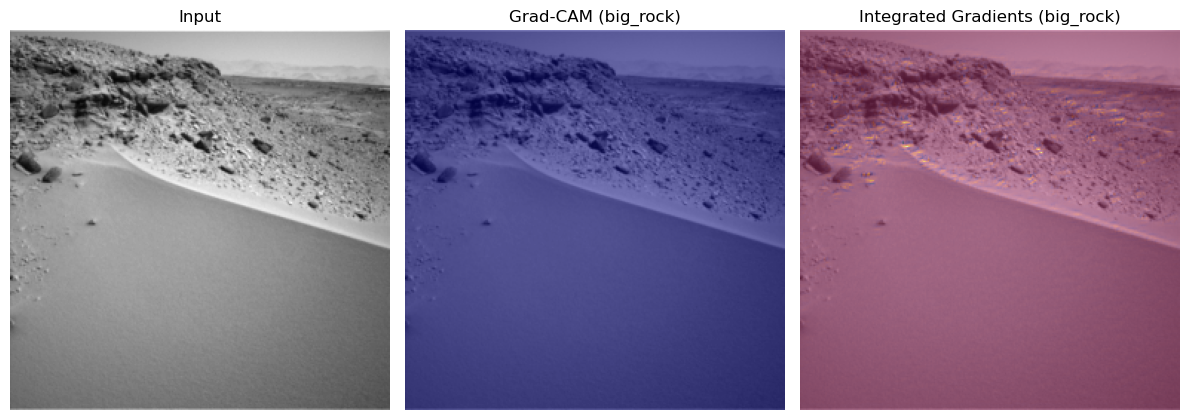

In [9]:
# Explainability demo:
# Grad-CAM, Integrated Gradients, Neural PCA for a single test image.
from explainability import explain_per_class_examples

num_examples_per_class = 1   # change as you like
ig_steps = 32

explain_per_class_examples(
    model=model,
    dataset=test_loader.dataset,
    device=device,
    num_examples_per_class=num_examples_per_class,
    ig_steps=ig_steps,
)


[neural PCA] Scanning dataset for class presence...
[neural PCA] Class 0: using 200 samples for PCA out of 6402 candidates.
[neural PCA] Class 1: using 200 samples for PCA out of 8351 candidates.
[neural PCA] Class 2: using 200 samples for PCA out of 4330 candidates.
[neural PCA] Class 3: using 200 samples for PCA out of 1756 candidates.

Class 'soil' (id=0), NPCA component 1, showing top 6 / 200 images.


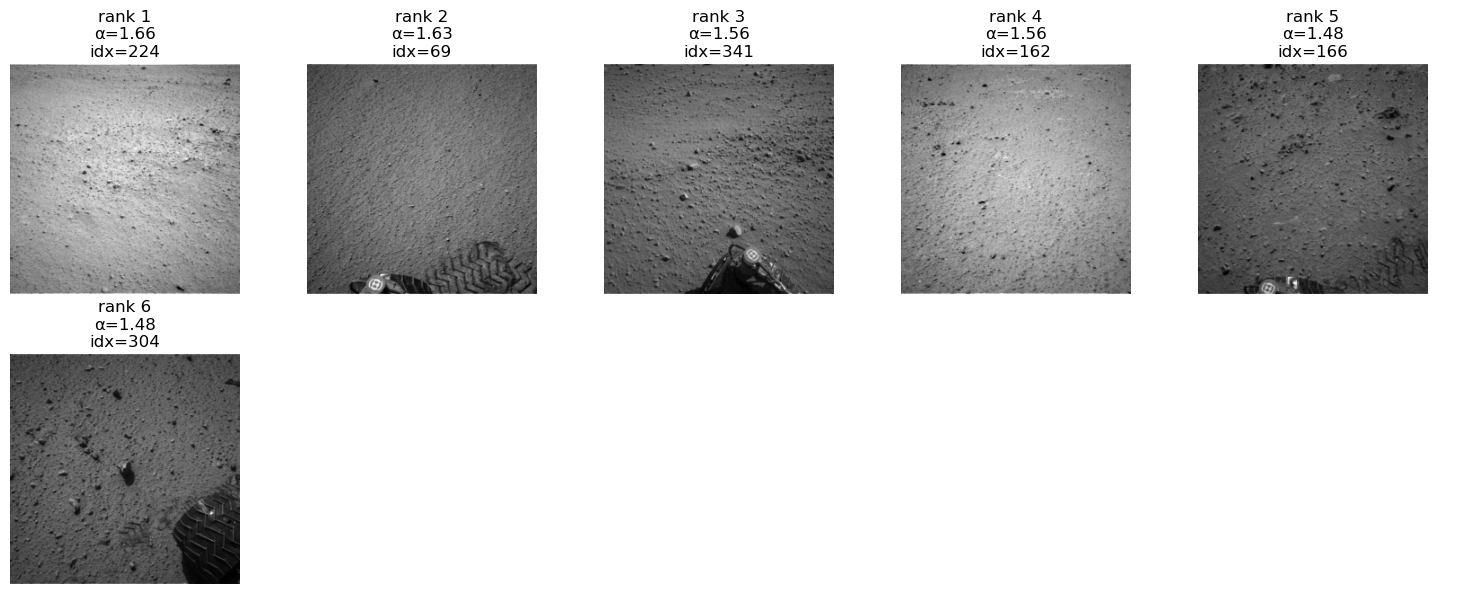


Class 'soil' (id=0), NPCA component 2, showing top 6 / 200 images.


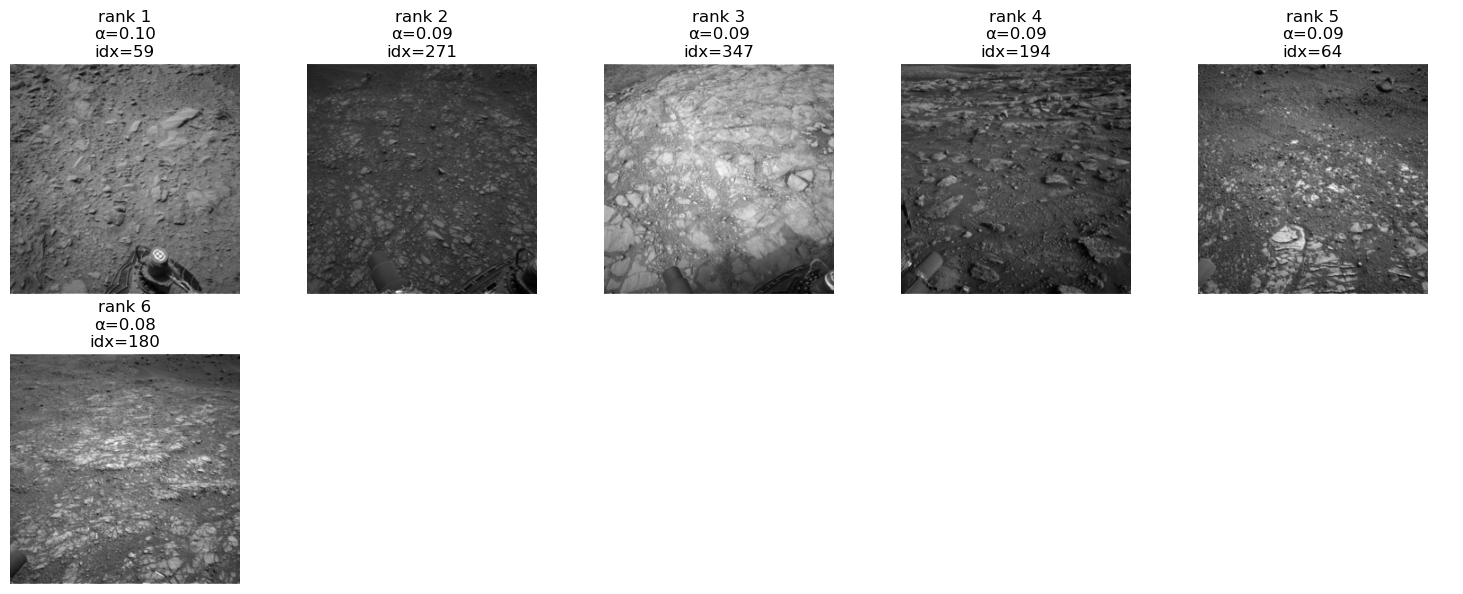


Class 'soil' (id=0), NPCA component 3, showing top 6 / 200 images.


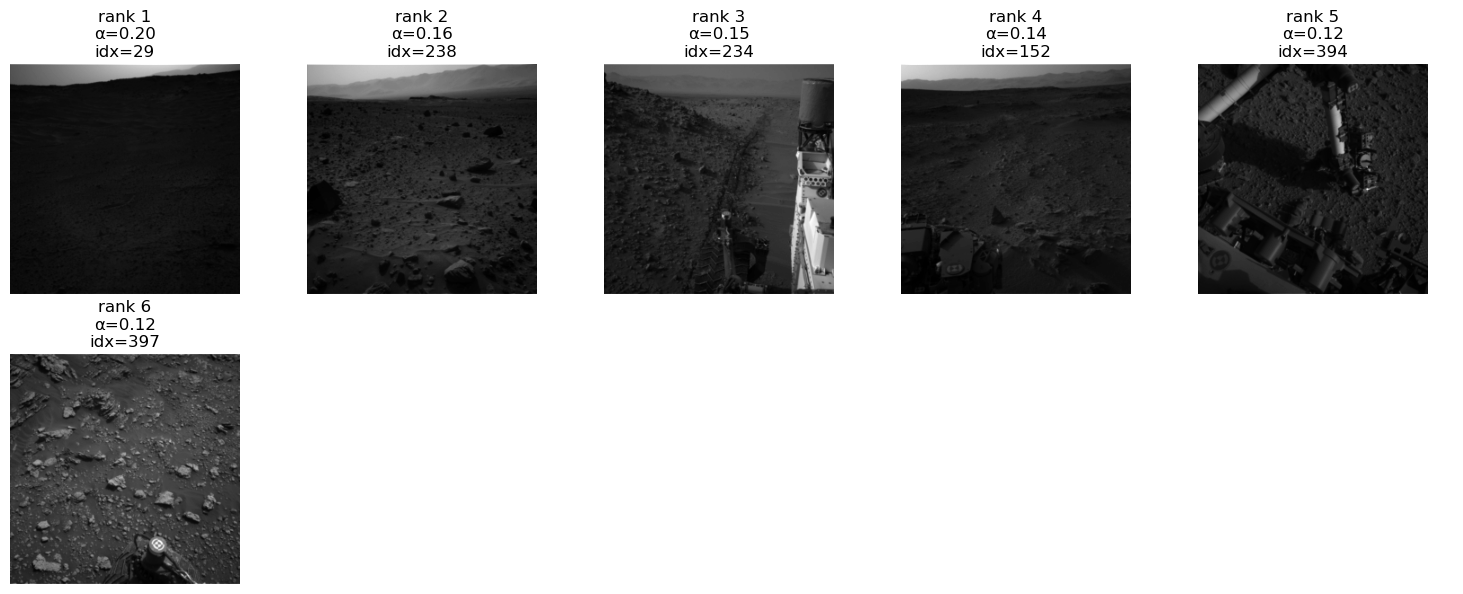


Class 'bedrock' (id=1), NPCA component 1, showing top 6 / 200 images.


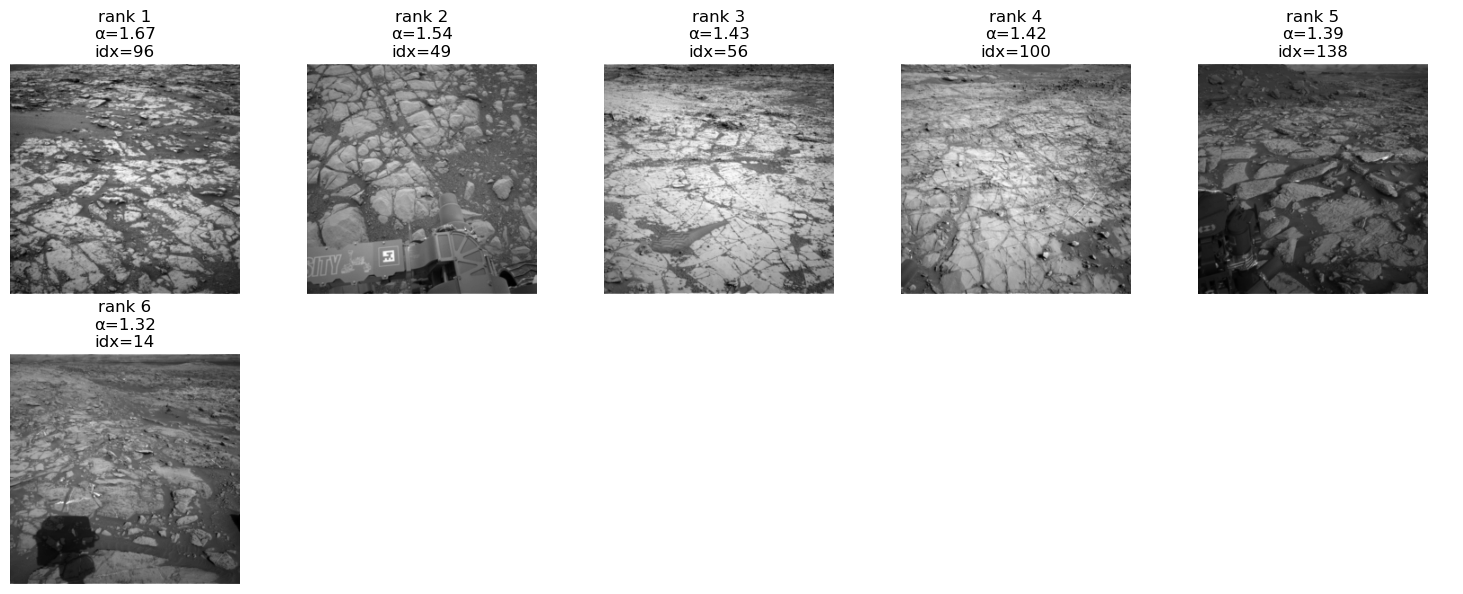


Class 'bedrock' (id=1), NPCA component 2, showing top 6 / 200 images.


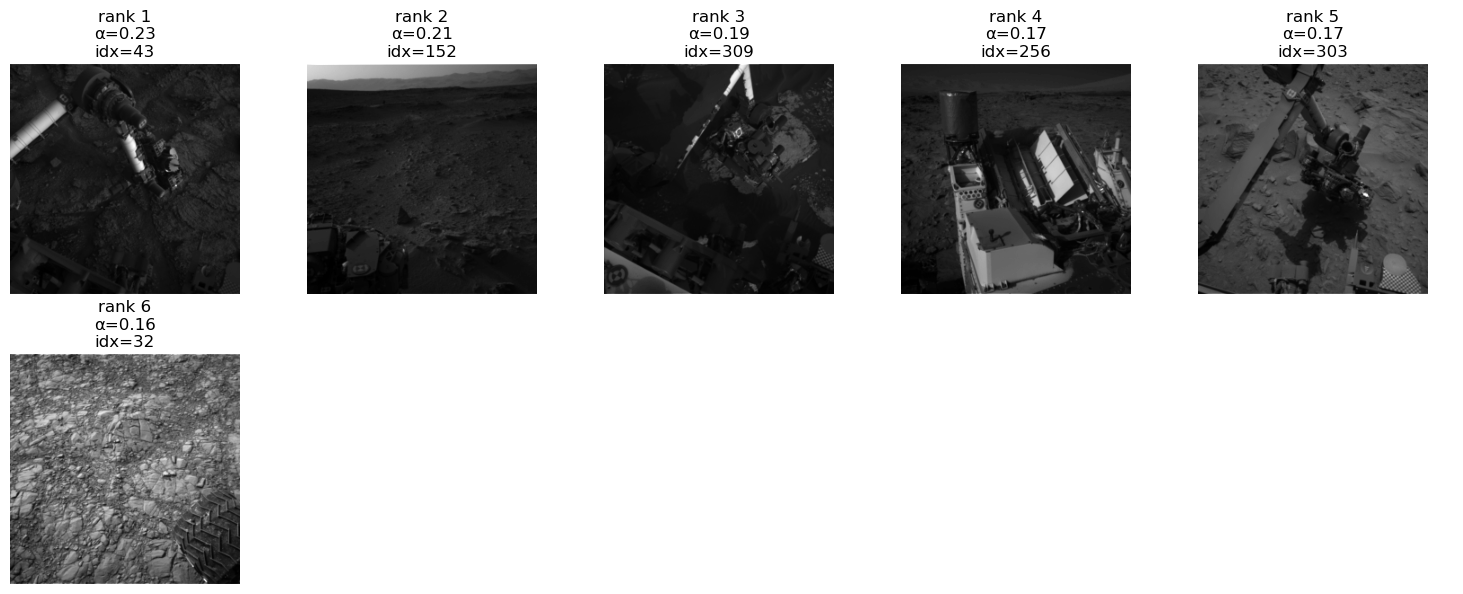


Class 'bedrock' (id=1), NPCA component 3, showing top 6 / 200 images.


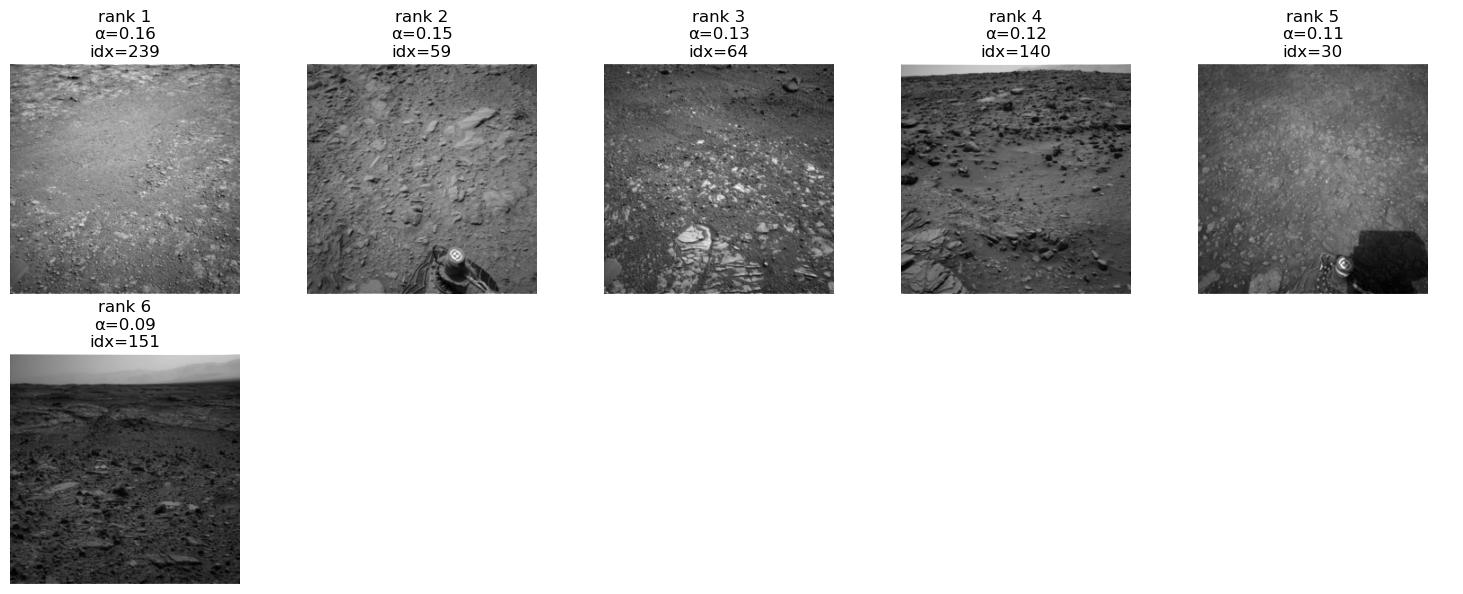


Class 'sand' (id=2), NPCA component 1, showing top 6 / 200 images.


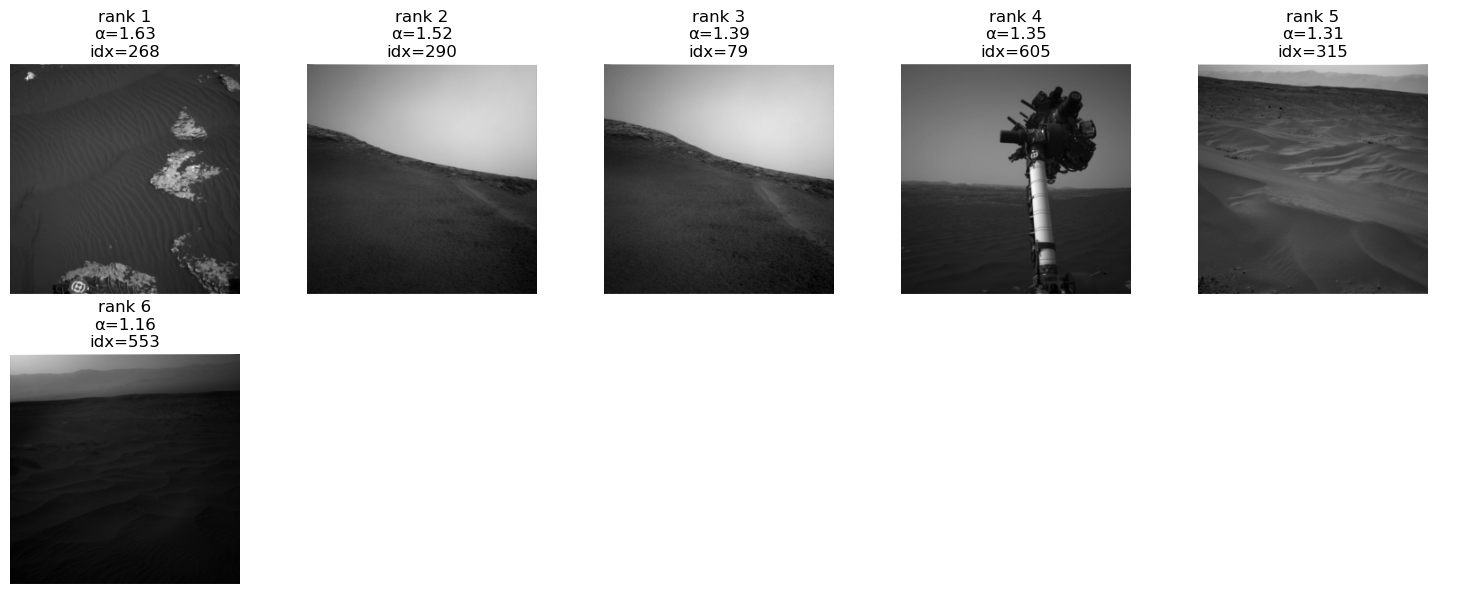


Class 'sand' (id=2), NPCA component 2, showing top 6 / 200 images.


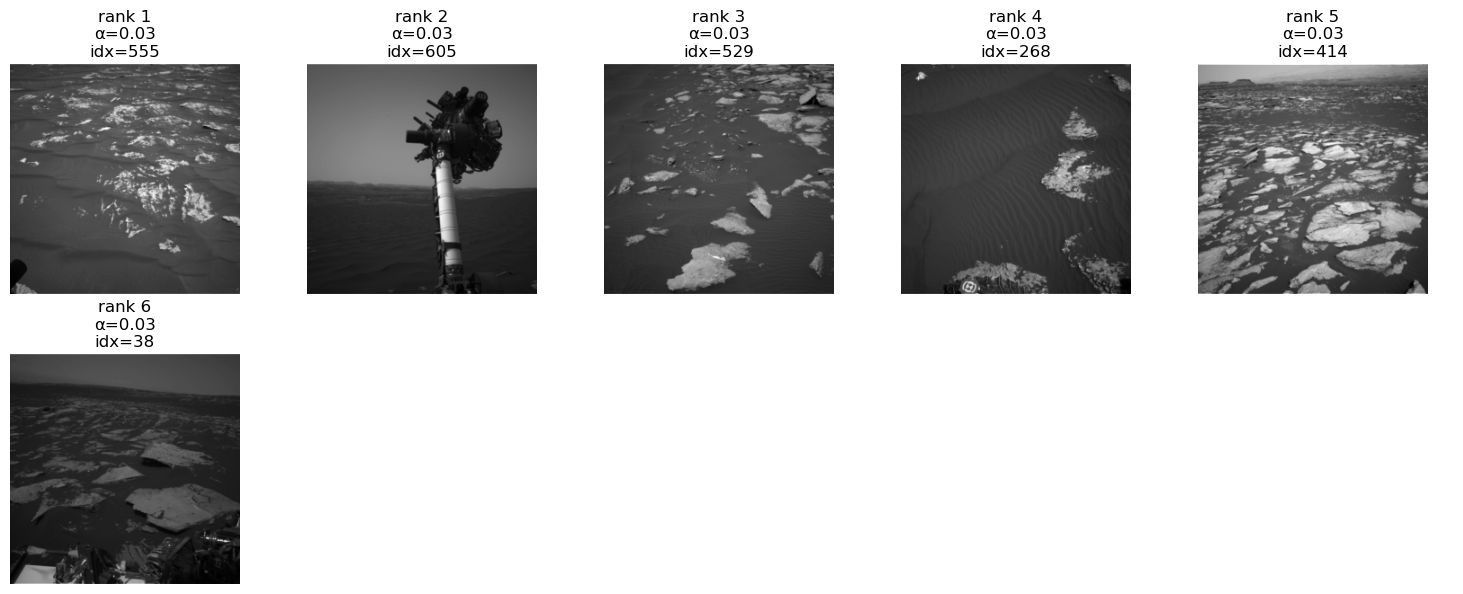


Class 'sand' (id=2), NPCA component 3, showing top 6 / 200 images.


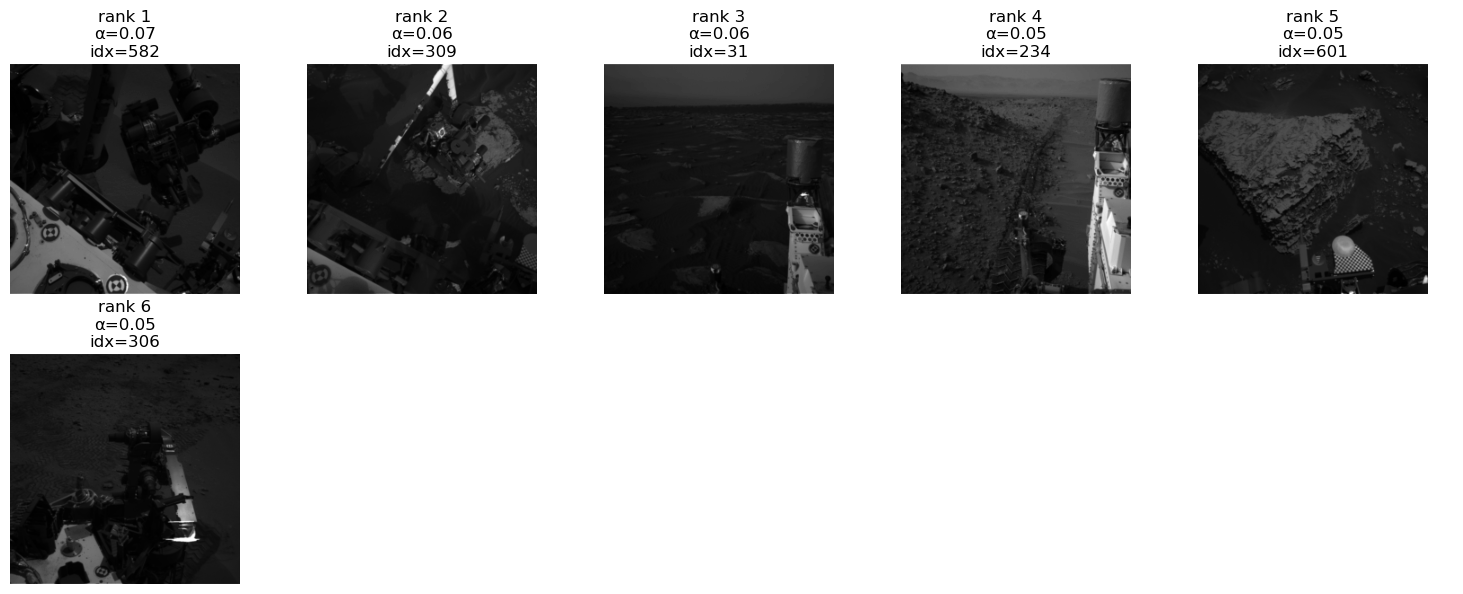


Class 'big_rock' (id=3), NPCA component 1, showing top 6 / 200 images.


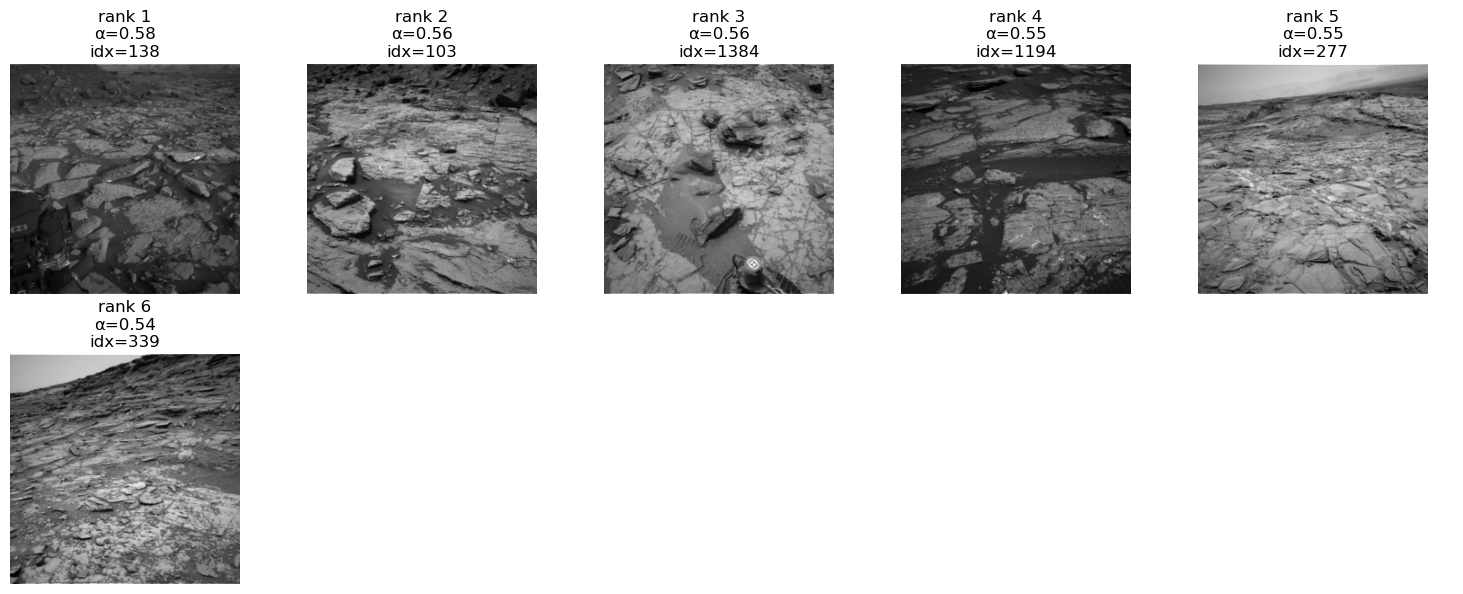


Class 'big_rock' (id=3), NPCA component 2, showing top 6 / 200 images.


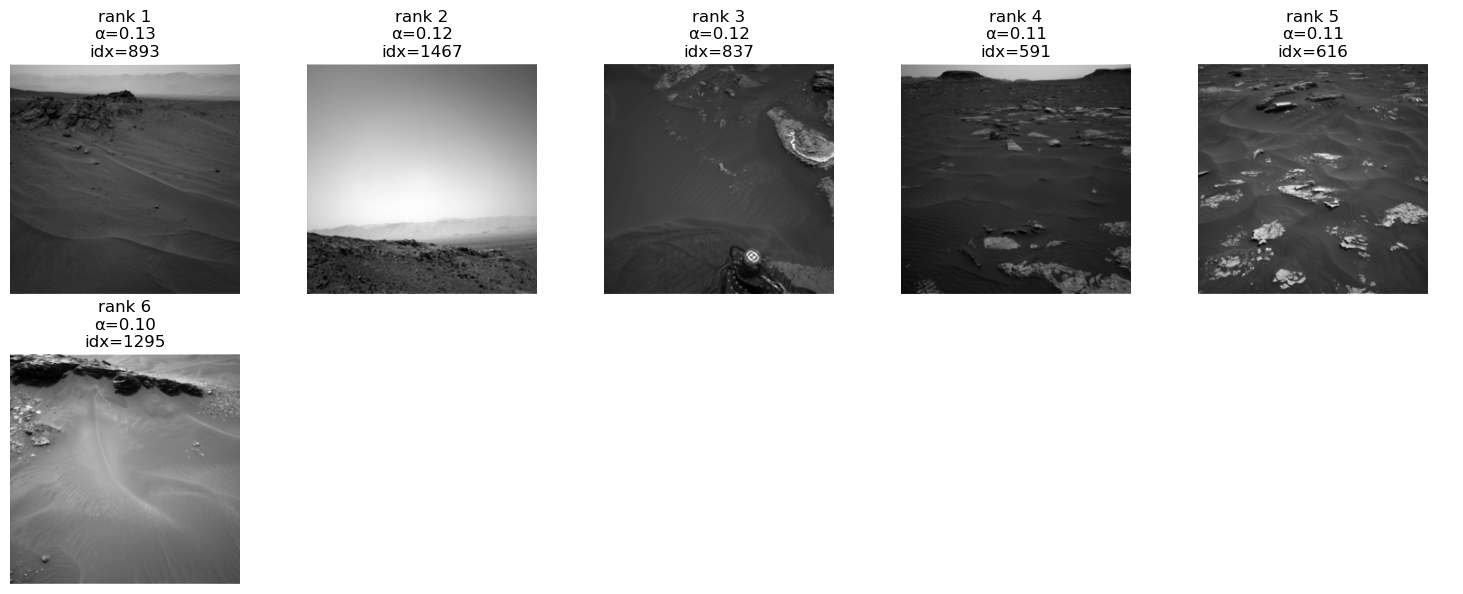


Class 'big_rock' (id=3), NPCA component 3, showing top 6 / 200 images.


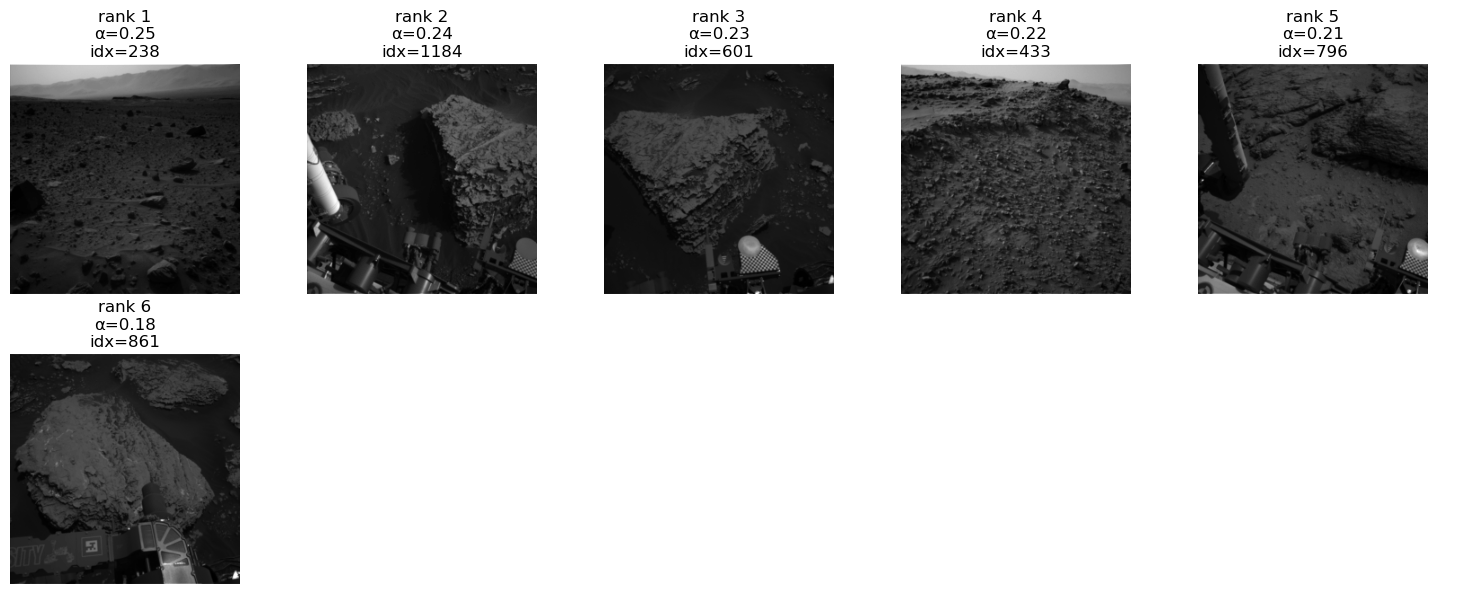

In [10]:
from explainability import compute_class_neural_pca_features, show_top_neural_pca_images_for_class

class_ids = list(range(len(AI4MARS_CLASS_NAMES)))  # [0,1,2,3]
max_samples_per_class = 200
n_pca_components = 3

neural_pca_results = compute_class_neural_pca_features(
    model=model,
    dataset=train_loader.dataset,   # usually use TRAIN set like in the paper
    device=device,
    class_ids=class_ids,
    max_samples_per_class=max_samples_per_class,
    n_components=n_pca_components,
    min_per_class=10,
)

for c in range(len(AI4MARS_CLASS_NAMES)):
    for comp in range(3):  # top 3 NPCA components
        show_top_neural_pca_images_for_class(
            neural_pca_results,
            dataset=train_loader.dataset,
            class_id=c,
            component_idx=comp,
            top_k=6,
        )
